June: Order of process for new resolution.

In [5]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

# 1. Realistic Bathymetry

[final_bathymetry.ipynb](http://nbviewer.jupyter.org/urls/bitbucket.org/CanyonsUBC/mackenzie_canyon/raw/tip/bathymetry/notebooks/final_bathymetry.ipynb)

* changed x_final and y_final (number of grid cells on x and y)
* smoothing takes really long (to do)

# 2. Idealized Bathymetry

[final_bathymetry.ipynb](http://nbviewer.jupyter.org/urls/bitbucket.org/CanyonsUBC/mackenzie_canyon/raw/tip/bathymetry/notebooks/final_bathymetry.ipynb)

* changed x_final and y_final (number of grid cells on x and y)

In [6]:
ideal_bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_quad.nc')

Current model resolution:  (360, 480)


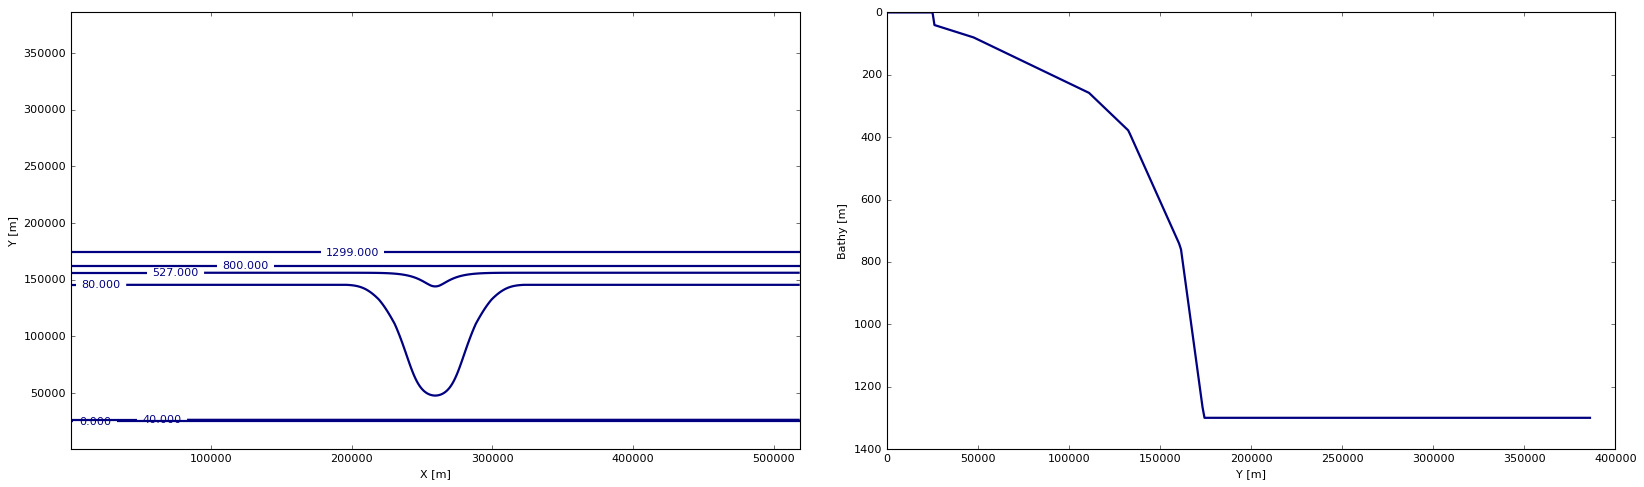

In [7]:
ibathy = ideal_bathy_file['Bathymetry'][:]
iX = ideal_bathy_file['X'][:]
iY = ideal_bathy_file['Y'][:]

print('Current model resolution: ', ibathy.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
plt.tight_layout(w_pad=5)
c1 = ax1.contour(iX, iY, ibathy, levels = [0, 40, 80, 527, 800, 1299], colors='Navy', linewidths=2)
ax1.clabel(c1, inline=1, fontsize=10)
ax1.set_xlabel('X [m]')
ax1.set_ylabel('Y [m]')

ax2.plot(iY[:,240], ibathy[:,240], color='Navy', linewidth=2)
ax2.invert_yaxis()
ax2.set_xlabel('Y [m]')
ax2.set_ylabel('Bathy [m]')
plt.show()

# 3. Geographic Grid

[final_bathymetry.ipynb](http://nbviewer.jupyter.org/urls/bitbucket.org/CanyonsUBC/mackenzie_canyon/raw/tip/bathymetry/notebooks/final_bathymetry.ipynb)

* changed x_final and y_final (number of grid cells on x and y)

In [8]:
grid_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/raw_coordinates/grid_quad.nc')

(483, 363) (483, 363)


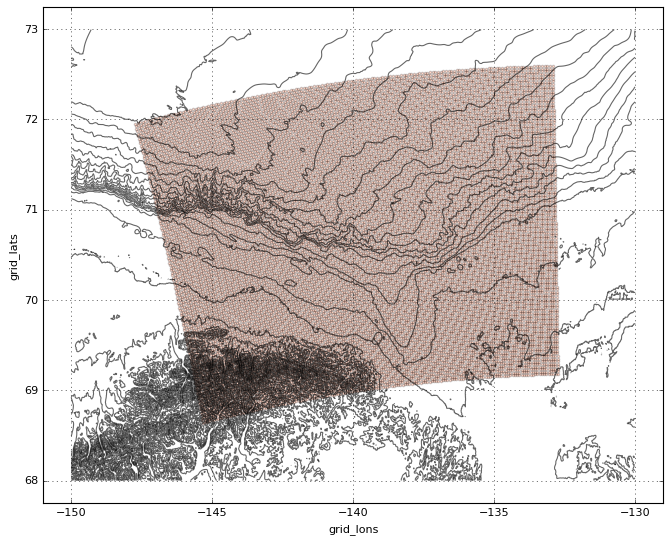

In [9]:
grid_lons = grid_file['grid_lons']
grid_lats = grid_file['grid_lats']

print(grid_lons.shape, grid_lats.shape)

x_region, y_region, z_region = functions_plot.def_regionG(-150, -130, 68, 73)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fig, ax = functions_plot.plot_region(fig, ax, x_region, y_region, z_region)
ax.scatter(grid_lons[::3,::3], grid_lats[::3,::3], c='orangered', s=5, alpha=0.2)
ax.grid(); ax.set_ylabel('grid_lats'); ax.set_xlabel('grid_lons')

# 4. Coordinates

In [10]:
coord_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_quad.nc')

(360, 480) (1, 360, 480)


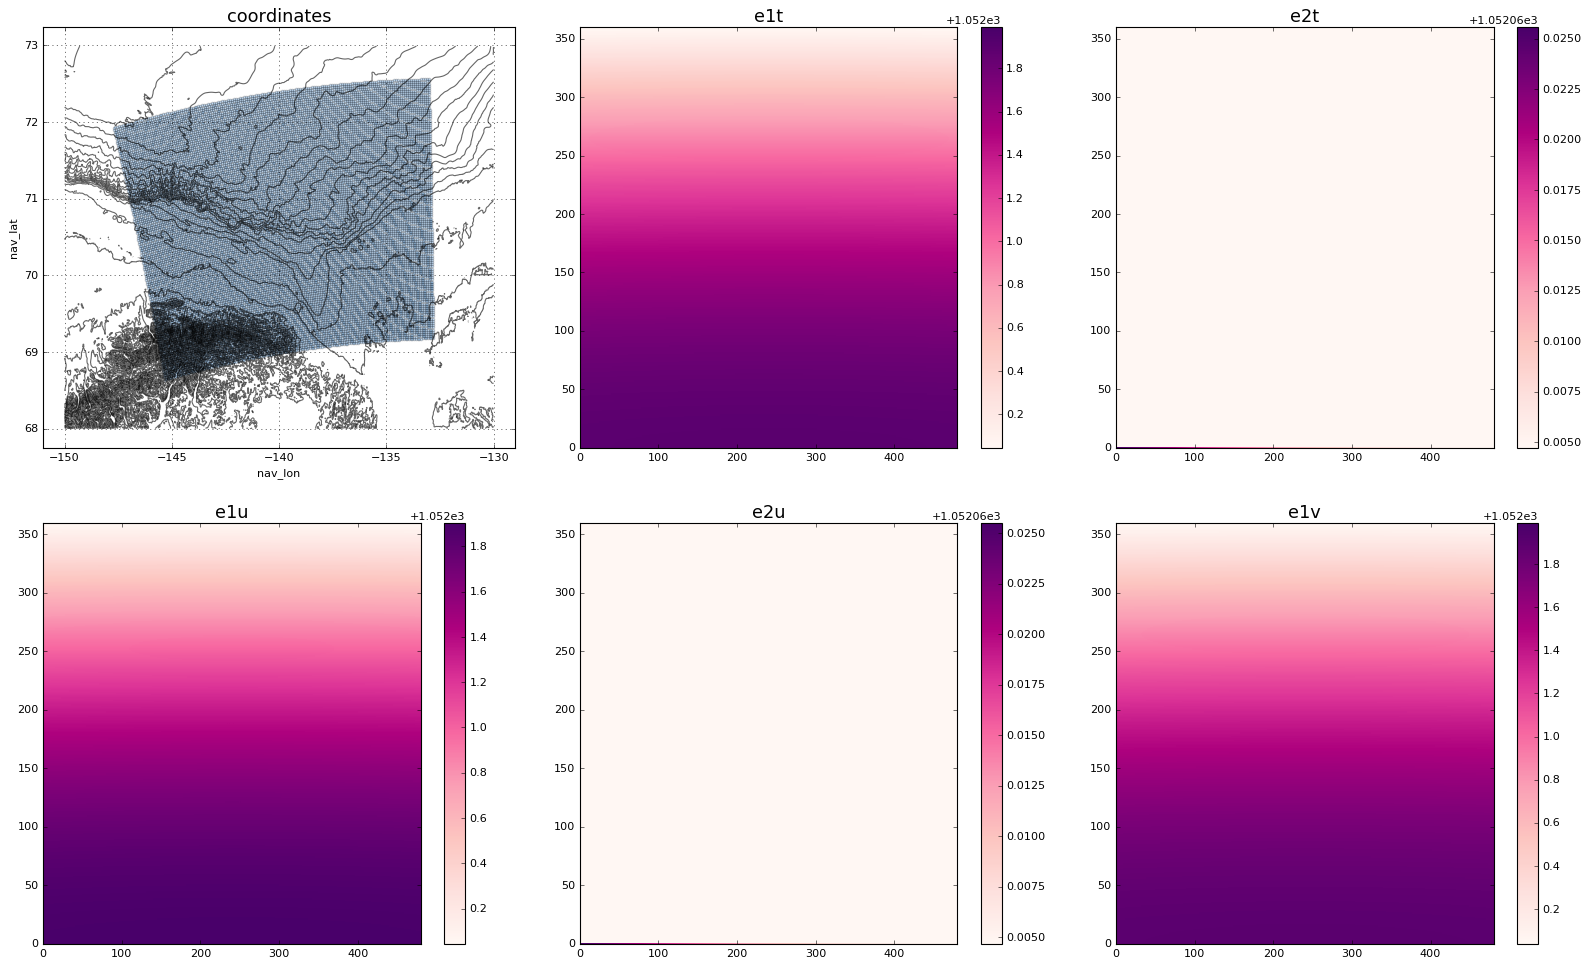

In [11]:
nav_lon = coord_file['nav_lon']
nav_lat = coord_file['nav_lat']
e1t = coord_file['e1t']
e2t = coord_file['e2t']
e1u = coord_file['e1u']
e2u = coord_file['e2u']
e1v = coord_file['e1v']

print(nav_lon.shape, e1t.shape)

fig, axs = plt.subplots(2,3, figsize=(20,12))
plt.tight_layout(h_pad=5, w_pad=3)
ax=axs.ravel()
ttls = ['coordinates', 'e1t', 'e2t', 'e1u', 'e2u', 'e1v']
for i, var, ttl in zip(np.arange(6), [None, e1t, e2t, e1u, e2u, e1v], ttls):
    if i==0:
        fig, ax[i] = functions_plot.plot_region(fig, ax[i], x_region, y_region, z_region)
        ax[i].scatter(nav_lon[::3,::3], nav_lat[::3,::3], c='dodgerblue', s=5, alpha=0.2)
        ax[i].set_ylabel('nav_lat'); ax[i].set_xlabel('nav_lon')
        ax[i].grid(); ax[i].set_title(ttl, fontsize=16)
    else:    
        p = ax[i].pcolor(var[0,:,:], cmap=cm.RdPu)
        fig.colorbar(p, ax=ax[i]); ax[i].set_title(ttl, fontsize=16)
        ax[i].set_xlim(0,var.shape[2]); ax[i].set_ylim(0,var.shape[1])

In [16]:
e1t[:].max(), e1t[:].min(), e1u[:].max(), e1u[:].min()

(1053.991839735392, 1052.0451390942867, 1053.9046758100715, 1052.0451288923903)

# 5. Depth Levels

[depth_levels.ipynb](http://nbviewer.jupyter.org/urls/bitbucket.org/CanyonsUBC/mackenzie_canyon/raw/tip/bathymetry/notebooks/depth_levels.ipynb)

* calculate new jpkdta, ppdzmin, ppkth, ppacr (leaving 80 m for now)
* change bathy and coords in yaml
* change jpidta, jpjdta, jpkdta in namcfg
* change nbdyend in nambdy_index
* run code and create mesh_mask.nc

In [8]:
mask_file = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/idealized/Resolution_quad_480x360/test_80levels/mesh_mask.nc')

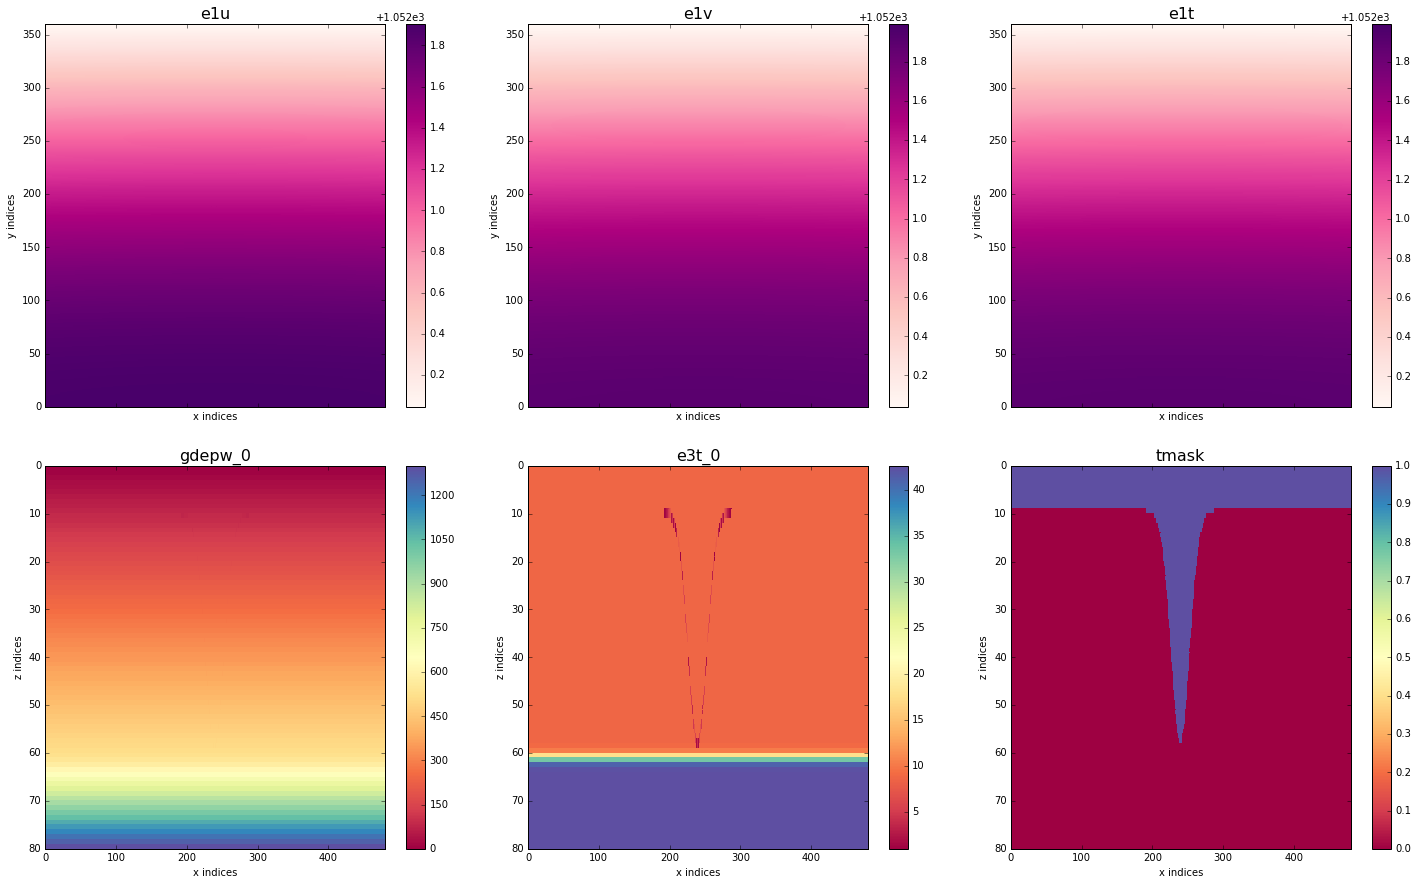

In [9]:
e1u = mask_file['e1u']
e1v = mask_file['e1v']
e1t = mask_file['e1t']
gdepw_1d = mask_file['gdepw_1d'][0,...]
gdepw_0 = mask_file['gdepw_0'][0,...]
e3t_0 = mask_file['e3t_0'][0,...]
tmask = mask_file['tmask'][0,...]

depth_shelf = gdepw_1d[np.argmin(np.abs(gdepw_1d - 80))]
ind_plane = np.argmin(np.abs(ibathy[:,0] - depth_shelf))

fig, axs = plt.subplots(2,3, figsize=(20,12), sharex=True)
plt.tight_layout(h_pad=5, w_pad=3)
ax=axs.ravel()
ttls = ['e1u', 'e1v', 'e1t', 'gdepw_0', 'e3t_0', 'tmask']
for i, var, ttl in zip(np.arange(6), [e1u, e1v, e1t, gdepw_0, e3t_0, tmask], ttls):
    ax[i].set_xlim(0,var.shape[-1]); ax[i].set_xlabel('x indices')
    if i==0 or i==1 or i==2:
        p = ax[i].pcolor(var[0,:,:], cmap=cm.RdPu)
        fig.colorbar(p, ax=ax[i]); ax[i].set_title(ttl, fontsize=16)
        ax[i].set_ylim(0,var.shape[1]); ax[i].set_ylabel('y indices')  
    else:
        p = ax[i].pcolor(var[:,ind_plane,:], cmap=cm.Spectral)
        fig.colorbar(p, ax=ax[i]); ax[i].set_title(ttl, fontsize=16)
        ax[i].invert_yaxis(); ax[i].set_ylabel('z indices')

# 6. Temperature and Salinity

[make_stratification.ipynb](http://nbviewer.jupyter.org/urls/bitbucket.org/CanyonsUBC/mackenzie_canyon/raw/tip/conditions/notebooks/make_stratification.ipynb)

* changed path_bath and path_mesh

In [10]:
temp_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/temperature/temperature_quad_80.nc')

In [11]:
sal_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_quad_80.nc')

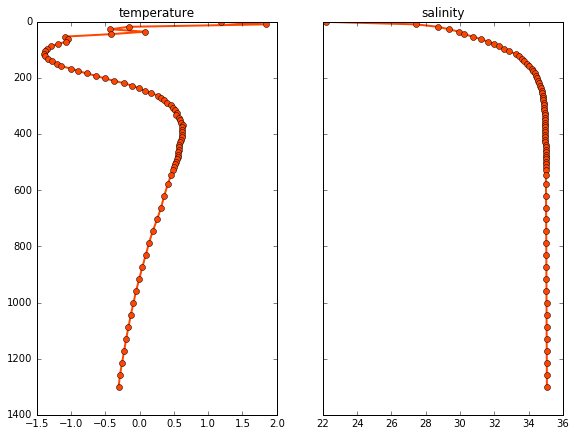

In [12]:
votemper = temp_file['votemper']
vosaline = sal_file['vosaline']
deptht = temp_file['deptht']

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,6), sharey=True)
plt.tight_layout(h_pad=5, w_pad=3)
ax1.plot(votemper[0,:,-1,-1], gdepw_1d, c='orangered', lw=2, marker='o')
ax2.plot(vosaline[0,:,-1,-1], gdepw_1d, c='orangered', lw=2, marker='o')
ax1.set_ylim(1400,0); ax2.set_ylim(1400,0)
ax1.set_title('temperature'); ax2.set_title('salinity')

# 7. SSH + Barotropic Velocities and Baroclinic Velocities

[ekman_velocities_boundary.ipynb](http://nbviewer.jupyter.org/urls/bitbucket.org/CanyonsUBC/mackenzie_canyon/raw/tip/conditions/notebooks/ekman_velocities_boundary.ipynb)

* changed bathy_file, grid_g, in_s, in_t, mesh_mask

In [13]:
tropic_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/bdy/bdy2d_quad_80_m01.nc')

In [14]:
clinic_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/bdy/bdy3d_quad_80_m01.nc')

In [33]:
vobtcrtx = tropic_file['vobtcrtx']
vobtcrty = tropic_file['vobtcrty']
vozocrtx = clinic_file['vozocrtx']
vomecrty = clinic_file['vomecrty']

In [51]:
gdepw_1d[10]

87.5

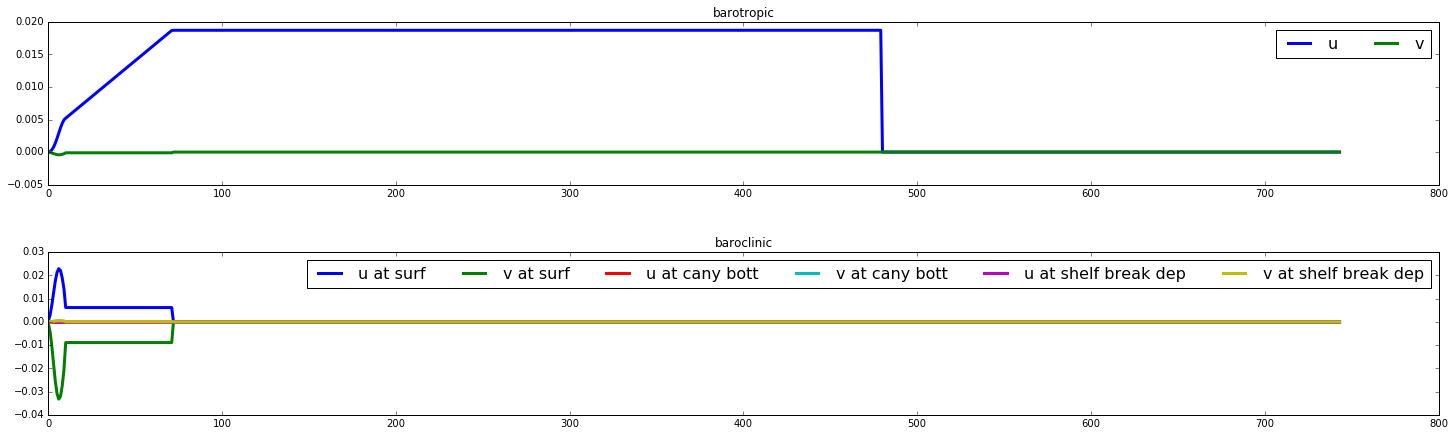

In [58]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,6))
plt.tight_layout(h_pad=5, w_pad=3); lw=3
ax1.set_title('barotropic'); ax2.set_title('baroclinic')
ax1.plot(vobtcrtx[:,0, -1], lw = lw, label='u')
ax1.plot(vobtcrty[:,0, -1], lw = lw, label = 'v')
ax2.plot(vozocrtx[:,0,0, -1], lw = lw, label='u at surf')
ax2.plot(vomecrty[:,0,0, -1], lw = lw, label = 'v at surf')
ax2.plot(vozocrtx[:,60,0, -1], lw = lw, label='u at cany bott')
ax2.plot(vomecrty[:,60,0, -1], lw = lw, label = 'v at cany bott')
ax2.plot(vozocrtx[:,9,0, -1], lw = lw, label='u at shelf break dep')
ax2.plot(vomecrty[:,9,0, -1], lw = lw, label = 'v at shelf break dep')
ax1.legend(ncol=2, fontsize=16); ax2.legend(ncol=6, fontsize=16)

# 8. Run


       nn_itend    =   28800
       nn_date0    =  20170101
       ln_rstart   =   .false.
       nn_euler    =        1
       nn_rstctl   =        0
       nn_stock    =   28800
       nn_write    =     600
       jpidta      =     480
       jpjdta      =     360
       jpkdta      =      80 
       ln_zps      = .true.
       rn_rdt      =   6.
       ppkth       =  62.0
       ppacr       =  1.0
       ppdzmin     =  8.75
       pphmax      =  1300.0
       ldbletanh   =  .FALSE.
       ln_bt_nn_auto =    .False.
       nn_baro       =    4
       sn_tem      = 'temperature/temperature_quad_80.nc'
       sn_sal      = 'salinity/salinity_quad_80.nc'
       bn_ssh      =     'bdy2d_quad_80' 
       bn_u2d      =     'bdy2d_quad_80' 
       bn_v2d      =     'bdy2d_quad_80' 
       bn_u3d      =    'bdy3d_quad_80' 
       bn_v3d      =    'bdy3d_quad_80' 
       bn_tem      =    'bdy3d_quad_80' 
       bn_sal      =    'bdy3d_quad_80' 
       nbdyend     = 480
       buffer_size = 10000000
       
       nemo_cmd.run INFO: 8410064.orca2.ibb
       